**Description:** This notebook is used to play a business case based on fictive data. 

**Project Name:** Logistic regression / Sigmoid regression

**Author:** Silas Mederer

**Date:** 2020-10-10

# Logistic regression

In this project we will work with fictive data on online ads, which will show whether a user clicked on an advertisement on a company's website or not. We will try to create a model that predicts whether or not a user will click on the advertisement based on user characteristics.

## Dashboard and set-up

In [1]:
import pandas as pd
import numpy as np

# vizualisation
import seaborn as sns
sns.set_palette("GnBu_d")
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

# warnings handler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %load eda_methods.py
def meta(df, transpose=True):
    """
    This function returns a dataframe that lists:
    - column names
    - nulls abs
    - nulls rel
    - dtype
    - duplicates
    - number of diffrent values (nunique)
    """
    metadata = []
    dublicates = sum([])
    for elem in df.columns:

        # Counting null values and percantage
        null = df[elem].isnull().sum()
        rel_null = round(null/df.shape[0]*100, 2)

        # Defining the data type
        dtype = df[elem].dtype

        # Check dublicates
        duplicates = df[elem].duplicated().any()

        # Check number of nunique vales
        nuniques = df[elem].nunique()


        # Creating a Dict that contains all the metadata for the variable
        elem_dict = {
            'varname': elem,
            'nulls': null,
            'percent': rel_null,
            'dtype': dtype,
            'dup': duplicates,
            'nuniques': nuniques
        }
        metadata.append(elem_dict)

    meta = pd.DataFrame(metadata, columns=['varname', 'nulls', 'percent', 'dtype', 'dup', 'nuniques'])
    meta.set_index('varname', inplace=True)
    meta = meta.sort_values(by=['nulls'], ascending=False)
    if transpose:
        return meta.transpose()
    print(f"Shape: {df.shape}")

    return meta

def data_loss(df_clean, df_raw):
    """
    This function returns the data loss in percent.
    """
    return f"{round((df_clean.shape[0]/df_raw.shape[0])*100,3)}% data loss"

def describe_plus(df, transpose=True):
    """
    This function returns a dataframe based on describ() function added:
    - skew()
    - kurtosis()
    - variance
    """
    statistics = pd.DataFrame(df.describe())
    skew       = pd.Series(df.skew())
    kurtosis   = pd.Series(df.kurtosis())
    variance   = pd.Series(df.var())

    statistics.loc['skew'] = skew
    statistics.loc['kurtosis'] = kurtosis
    statistics.loc['variance'] = variance

    if transpose:
        return round(statistics.transpose(), 2)
    return round(statistics, 2)

def correlogram(df):
    """
    This function plots a correlogram.
    """
    #Plot
    fig, ax = plt.subplots(figsize=(15, 10))
    mask = np.triu(df.corr())
    ax = sns.heatmap(round(df.corr()*100, 0),
                     annot=True,
                     mask=mask, cmap="Blues")
    return df.corr()

def plot_train_test_split(y, y_train, y_test):
    """
    This function plots the the sizes of training and test set.
    Also you will get a dataframe with the number of values and the relative distribution.
    """
    # plot
    y.plot.hist()
    y_train.plot.hist()
    y_test.plot.hist()

    # dataframe with relative and absolut values
    plt.legend(['all', 'train', 'test'])
    storage = pd.DataFrame()
    storage['train abs'] = round(y_train.value_counts(), 2)
    storage['train %']   = round((y_train.value_counts()/y_train.shape[0]), 2)
    storage['test abs']  = round(y_test.value_counts(), 2)
    storage['test %']    = round((y_test.value_counts()/y_test.shape[0]), 2)
    storage['all abs']   = round(y.value_counts(), 2)
    storage['all %']     = round((y.value_counts()/y.shape[0]), 2)

    # prints informations about splits
    print ("Training set has {} samples.".format(y_train.shape[0]))
    print ("Testing set has {} samples.".format(y_test.shape[0]))
    return storage


## Load and check data

In data science we start every project with a business understanding. Afterwards we check and clean the data if necessary. Here we check for null values, the data types, column names and we handle outliers.
The data set includes the following:

* 'Daily Time Spent on Site' in minutes
* 'Age' in years
* 'Area Income' in dollar
* 'Daily Internet Usage'
* 'Ad Topic Line' headline as string
* 'City' as string
* 'Male' as bool male =1, not male = 0
* 'Country' as string
* 'Timestamp'
* 'Clicked on Ad' as bool if klicked = 1 else 0

In [3]:
df = pd.read_csv("data/Advertising.csv")

In [4]:
df.head(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0


In [5]:
df.tail(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0
999,45.01,26,29875.80,178.35,Virtual 5thgeneration emulation,Ronniemouth,0,Brazil,2016-06-03 21:43:21,1


In [6]:
describe_plus(df)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,variance
Daily Time Spent on Site,1000.0,65.00,15.85,32.60,51.36,68.22,78.55,91.43,-0.37,-1.10,2.513400e+02
Age,1000.0,36.01,8.79,19.00,29.00,35.00,42.00,61.00,0.48,-0.40,7.719000e+01
Area Income,1000.0,55000.00,13414.63,13996.50,47031.80,57012.30,65470.64,79484.80,-0.65,-0.10,1.799524e+08
Daily Internet Usage,1000.0,180.00,43.90,104.78,138.83,183.13,218.79,269.96,-0.03,-1.27,1.927420e+03
Male,1000.0,0.48,0.50,0.00,0.00,0.00,1.00,1.00,0.08,-2.00,2.500000e-01
Clicked on Ad,1000.0,0.50,0.50,0.00,0.00,0.50,1.00,1.00,0.00,-2.00,2.500000e-01


In [7]:
meta(df).T

,nulls,percent,dtype,dup,nuniques
varname,,,,,
Daily Time Spent on Site,0,0,float64,True,900
Age,0,0,int64,True,43
Area Income,0,0,float64,False,1000
Daily Internet Usage,0,0,float64,True,966
Ad Topic Line,0,0,object,False,1000
City,0,0,object,True,969
Male,0,0,int64,True,2
Country,0,0,object,True,237
Timestamp,0,0,object,False,1000


**Observations:** The dataframe is 1.000 entries long. It has 10 columns 6 of them are numeric and 4 objects (string and date). We do not need to handle missing but will check for outliers in the explorative data analysis. We will rename the columns and drop City, Ad Topic Line and Timestamp because they have to many different entries (see nuniques) and are categorial.

In [8]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

In [9]:
df.drop(columns=["City", "Ad_Topic_Line", "Timestamp"], 
        inplace=True,
        axis=1)
df.head(3)

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Male,Country,Clicked_on_Ad
0,68.95,35,61833.90,256.09,0,Tunisia,0
1,80.23,31,68441.85,193.77,1,Nauru,0
2,69.47,26,59785.94,236.50,0,San Marino,0


## EDA
The explorative data analysis is used to get an impression of the data. We take a look on the distribution, visualize correlations, use crosstables and groupby to form hypotheses.

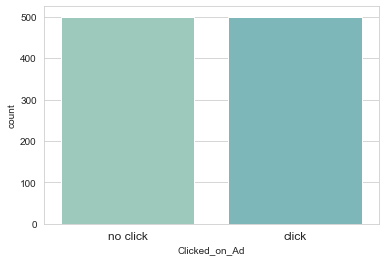

In [10]:
# label "Clicked_on_Ad"

sns.countplot(x='Clicked_on_Ad',data=df);
plt.xticks(np.arange(2), ('no click', 'click',), fontsize=12);

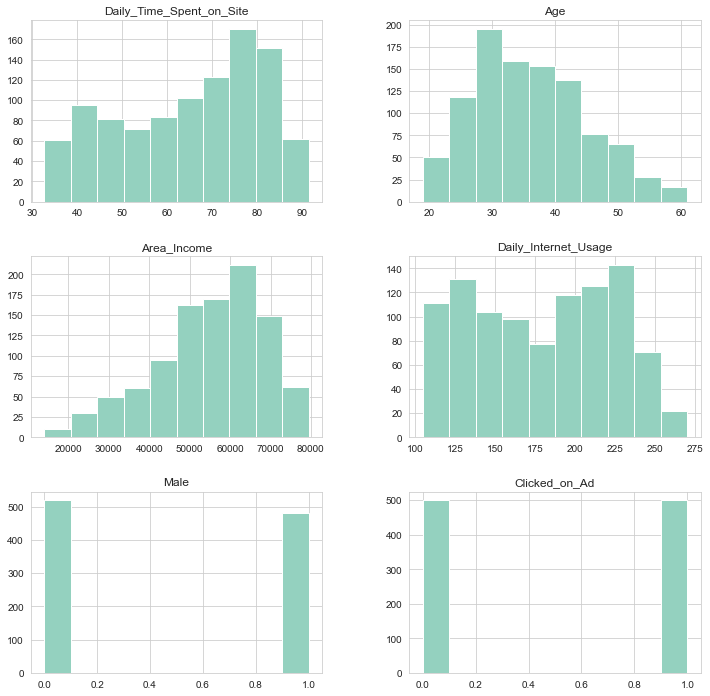

In [11]:
# plot histogram with 10 bins of all numeric features

_ = df.hist(figsize=(12,12))
plt.savefig('figures/hist.png')

**Observations:** The bin 30 to 40 have the highest counts. The biggest income bin is at 65.000 and more than 200 people have lower than 45.000 income. The daily internet use is in every entries above 100 minutes and the highest bin is 225 minutes. The daily time spent on site is mostly around 80 minutes. The Male and Clicked_on_Ad feature are Boolean, but we can see that they are balanced, which makes it easy to predict.

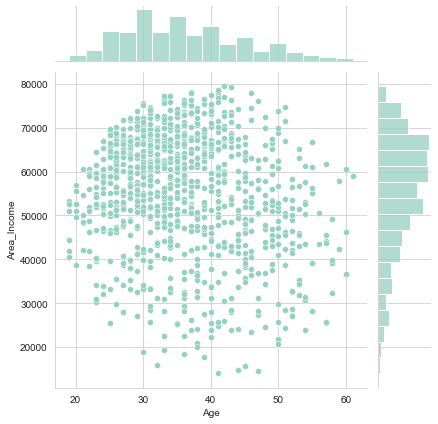

In [12]:
sns.jointplot(x="Age", y="Area_Income", data=df);

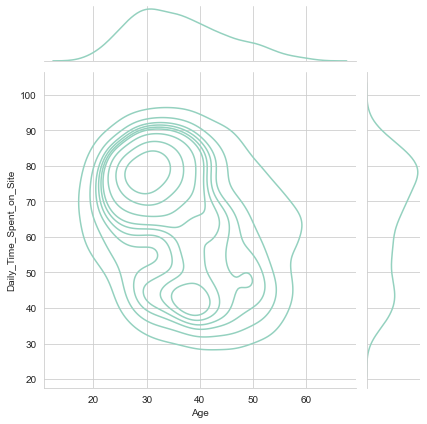

In [13]:
sns.jointplot(x="Age", y="Daily_Time_Spent_on_Site", data=df, kind="kde");

**Observations:** We can see a concentration in the ages 30 and Daily Time Spent on Site 80 min. 

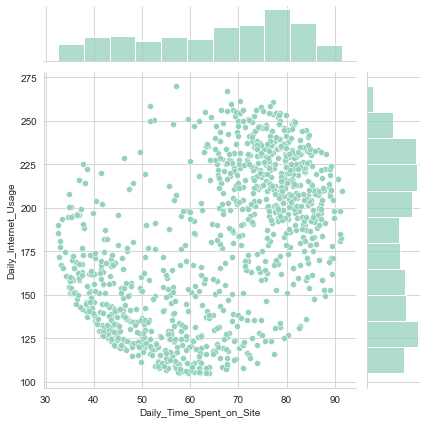

In [14]:
sns.jointplot(x="Daily_Time_Spent_on_Site", y="Daily_Internet_Usage", data=df);

**Oberservation:** The Daily_Internet_Usage_Time is equally distributed. We can see two hotspots at 125 min and 225.

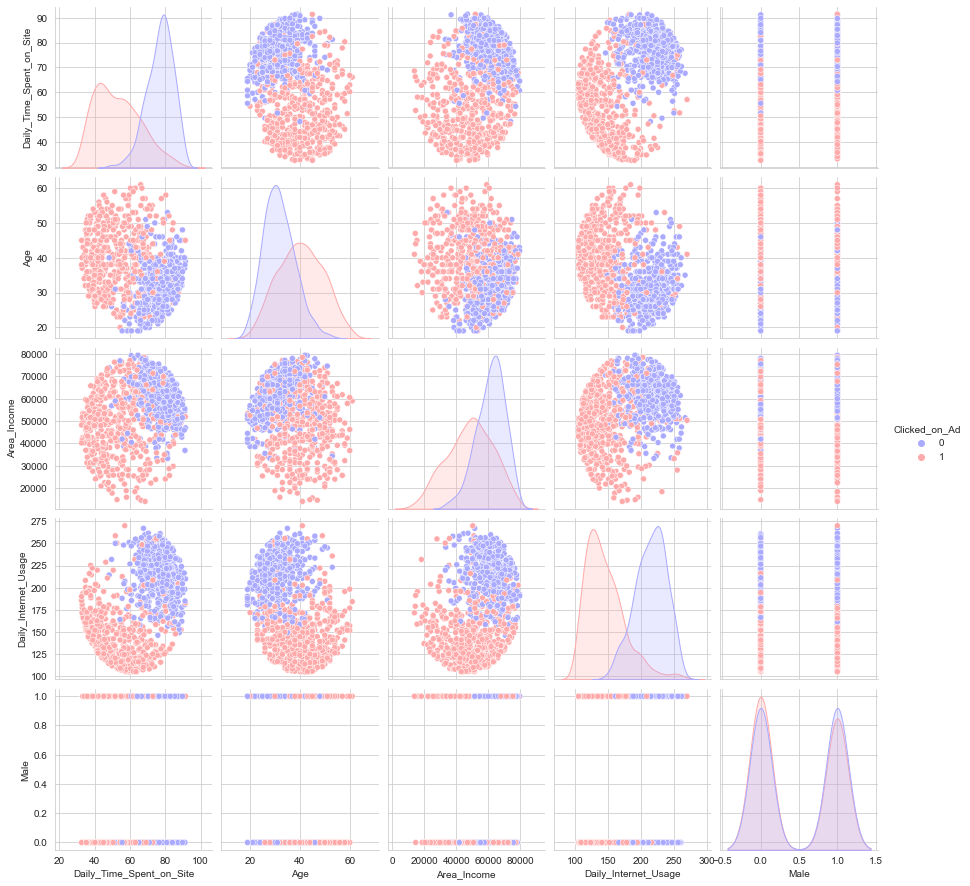

In [15]:
sns.pairplot(df, hue="Clicked_on_Ad", palette="bwr");
plt.savefig('figures/pairplot.png')

**Observations:** It seems the higher the income and the internet usage, the lesser the people click on ad.

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Male,Clicked_on_Ad
Daily_Time_Spent_on_Site,1.000000,-0.331513,0.310954,0.518658,-0.018951,-0.748117
Age,-0.331513,1.000000,-0.182605,-0.367209,-0.021044,0.492531
Area_Income,0.310954,-0.182605,1.000000,0.337496,0.001322,-0.476255
Daily_Internet_Usage,0.518658,-0.367209,0.337496,1.000000,0.028012,-0.786539
Male,-0.018951,-0.021044,0.001322,0.028012,1.000000,-0.038027
Clicked_on_Ad,-0.748117,0.492531,-0.476255,-0.786539,-0.038027,1.000000


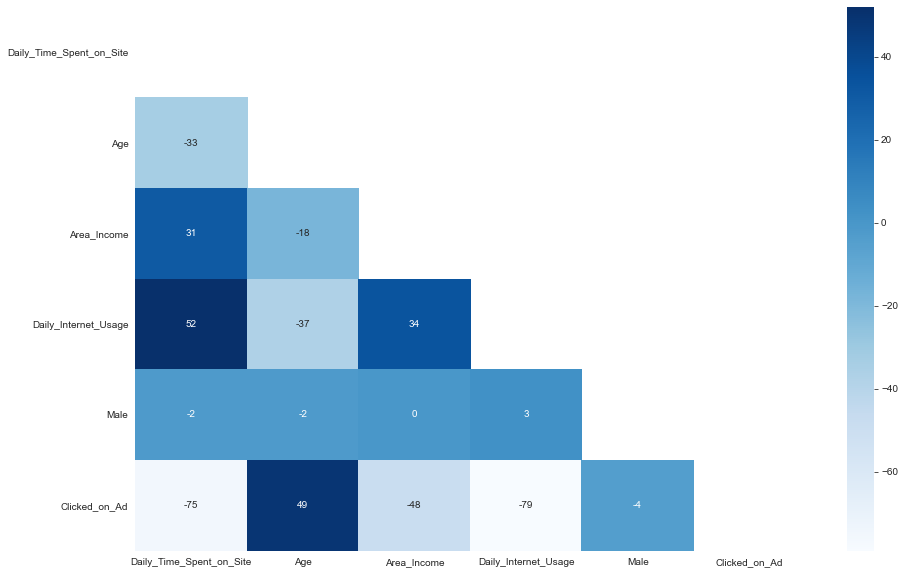

In [16]:
correlogram(df)

**Obersvations:** We can find strong negative correlation between the features "Daily_Time_Spent_on_Site", "Area_Income" and "Daily_Internet_Usage". Only the "Age" feature is positive correlated to the target.

In [17]:
# check if there are countries more than once if so we will dummie them

more_five_countries = df["Country"].value_counts() > 1
more_five_countries.value_counts()

True     223
False     14
Name: Country, dtype: int64

## Feature engineering
We need to handle the object data in the country column. It can be used thus there are a few countries more frequent.

In [18]:
y = df.Clicked_on_Ad
X = df.drop("Clicked_on_Ad", axis=1)
X.head(3)

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Male,Country
0,68.95,35,61833.90,256.09,0,Tunisia
1,80.23,31,68441.85,193.77,1,Nauru
2,69.47,26,59785.94,236.50,0,San Marino


In [19]:
print(f"Without dummies {X.shape}")
X = pd.get_dummies(df.copy(), drop_first=True)
print(f"With dummies {X.shape}")

Without dummies (1000, 6)
With dummies (1000, 242)


## Logistic regression

We will create our model, first we need to split the data and than we will define, train and test it. 

### Spilt

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Training set has 700 samples.
Testing set has 300 samples.


,train abs,train %,test abs,test %,all abs,all %
0,354,0.51,146,0.49,500,0.5
1,346,0.49,154,0.51,500,0.5


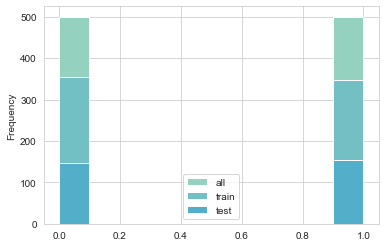

In [22]:
# check the balance should be around around 50/50

plot_train_test_split(y, y_train, y_test)


### Train and fit baseline model

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
log_reg = LogisticRegression(verbose=1)
log_reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(verbose=1)

In [25]:
predictions = log_reg.predict(X_test)

### Evaluate basline model

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [27]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       146
           1       0.96      0.84      0.89       154

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



**Observations:** In the classification report we can see that we predicted 85% of the people whom klicked on the not ad and 96% from whom klicked on the ad correct (precission). The recall shows use how many postive instances (in relation to all instances) the model predicted correct. The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. Overall the model fits great and can be deployed.

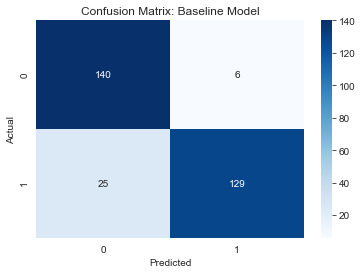

In [28]:
confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(predictions), colnames=["Predicted"], rownames=["Actual"])

sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

plt.title('Confusion Matrix: Baseline Model')
plt.savefig('figures/conf-matrix-base.png')

**Observation:** The confusion matrix for the baseline model shows that we predicted 140 true-negatives, these 140 did not click the ad and were predicted to do so. The true-positive value 129 shows the people that did klick the ad and were predicted as they did. Only 6 klicks were predicted false-negative, so we predicted they would click, but they did not - so called second type error. The 25 false-positives were predicted as they would not klick, but they clicked the ad - so called first type error.

### Optimize with RandomizedSearchCV

Now let’s have a look if we can tune the model by using the hyperparameter. We will focus on the F1 score because this is the harmonic mean between precission and recall.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
# Hyperparameter grid
C = np.logspace(0, 4, num=10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# Estimator for use in random search
estimator = LogisticRegression()

# Create the random search model
logreg = RandomizedSearchCV(estimator, hyperparameters,
                            n_jobs=-1,
                            scoring='f1',
                            cv=5,
                            n_iter=25,
                            verbose=2)

# Fit
logreg.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.5s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='f1', verbose=2)

In [31]:
print(logreg.best_params_)
print(round(logreg.best_score_,2))

{'solver': 'liblinear', 'penalty': 'l1', 'C': 3593.813663804626}
1.0


In [32]:
predictions_opt = logreg.predict(X_test)

In [33]:
print(classification_report(y_test, predictions_opt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00       154

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**Observations:** As we can see the hyperparameter tuning has paid of, now the model has the perfect scores of 1, which means we can predict every (recall) case in the test data and precisely in the correct group (precision). As proof you can find a confusion matrix plot below. If recall and precision is 1 F1 is 1 too.

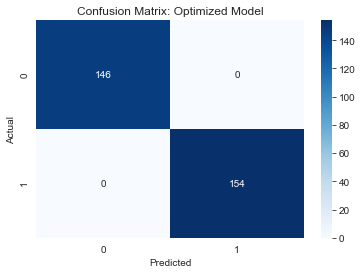

In [34]:
confusion_matrix = pd.crosstab(y_test, predictions_opt, rownames=['Actual'], colnames=['Predicted'])
conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(predictions_opt), colnames=["Predicted"], rownames=["Actual"])

sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")

plt.title('Confusion Matrix: Optimized Model')
plt.savefig('figures/conf-matrix-opt.png')

## Evaluate the test group
So we build and trained a perfect model, but now lets check whom we rechead with our predictions. How much money do they have (projected area income), where do they come from, which gender? To answer the question could help the stakeholder to target the group. 

In [35]:
# first we join the predictions_opt and the X_test in our case the columns "Clicked_on_Ad" 
# and "Predictions" are equal, cause we predicted with 1.00 precision.

X_test["Predictions"] = predictions_opt.tolist()
X_test.head(2)

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Male,Clicked_on_Ad,Country_Albania,Country_Algeria,Country_American Samoa,Country_Andorra,...,Country_Uzbekistan,Country_Vanuatu,Country_Venezuela,Country_Vietnam,Country_Wallis and Futuna,Country_Western Sahara,Country_Yemen,Country_Zambia,Country_Zimbabwe,Predictions
521,63.26,29,54787.37,120.46,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
737,71.23,52,41521.28,122.59,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# drop dummie columns

X_test.columns
df = X_test[['Daily_Time_Spent_on_Site', 'Age', 'Area_Income',
            'Daily_Internet_Usage', 'Male', 'Clicked_on_Ad', 'Predictions']]
df.head(2)

,Daily_Time_Spent_on_Site,Age,Area_Income,Daily_Internet_Usage,Male,Clicked_on_Ad,Predictions
521,63.26,29,54787.37,120.46,1,1,1
737,71.23,52,41521.28,122.59,0,1,1


In [37]:
df.groupby("Predictions").Age.describe()

,count,mean,std,min,25%,50%,75%,max
Predictions,,,,,,,,
0,146.0,31.006849,5.474073,19.0,28.0,31.0,34.00,46.0
1,154.0,39.636364,8.572504,22.0,33.0,40.0,46.75,60.0


In [38]:
df.groupby("Predictions").Male.count()

Predictions
0    146
1    154
Name: Male, dtype: int64

In [39]:
df_plots = df[['Daily_Time_Spent_on_Site', 'Age', 'Area_Income', 'Daily_Internet_Usage', 'Male', 'Predictions']]

**Observations:** As you see a few of the 

## Plots of test group
Here we can see the feature distributions of the people that clicked (1) and these that did not (0). We can give this to the marketing department, so they know which customers they missed and can change their strategy. These plots were more important if our model has first or second degree errors to evaluate these that we missed. As we have a very good model it is not necessary to look at what is behind the false-positives or false-negatives. I did it anyway.

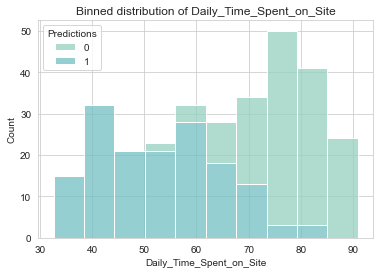

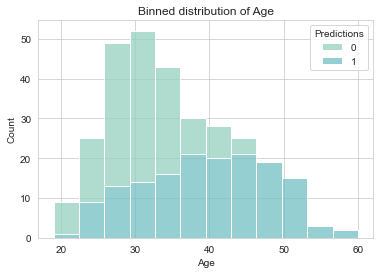

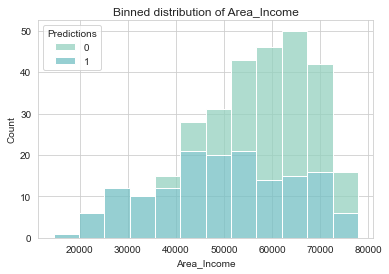

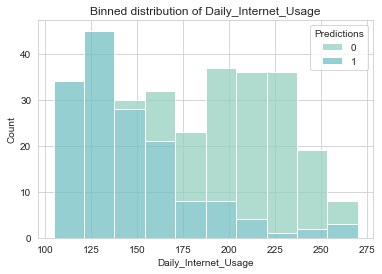

In [40]:
for elem in ['Daily_Time_Spent_on_Site', 'Age', 'Area_Income', 'Daily_Internet_Usage']:
    sns.histplot(df_plots, x=elem, hue="Predictions", multiple="stack");
    plt.title(f"Binned distribution of {elem}")
    plt.show()
    plt.close()

**Observation:**
- As more time the user spent on the site, the less him or her klicken the add. Most users clicked after 40 minutes and after 65 minutes we se a drop.
- The younger the users, the lesser they clicked the ad.
- If we have a look on the area income we can see the there is definitely a potential in the that we missed. 
- The daily time of internet use looks contradictorily to the time on our site. Would be interesting to find the reason why people that use the internet shorter clicked the ad more often. It might be that these users are more focused in their consumption. 